In [50]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [51]:
data = pd.read_csv("Top_5_Leagues_23_24.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [52]:
info = pd.read_csv("T5 Leagues Mins 23-24.csv" , low_memory=False)
info

,Unnamed: 0,player,team,age,position,Mins,Passing Accuracy
0,0,Bukayo Saka,Arsenal,22,"D(L),M(CLR)",2937,83.0
1,1,Rodri,Man City,28,"D(C),DMC",2937,92.5
2,2,Michael Olise,Crystal Palace,22,AM(CLR),1277,83.1
3,3,Kevin De Bruyne,Man City,32,"M(CLR),FW",1228,83.8
4,4,Phil Foden,Man City,24,"AM(CLR),FW",2869,89.1
...,...,...,...,...,...,...,...
2856,2856,Vignon Ouotro,Strasbourg,18,Forward,7,50.0
2857,2857,Adrian Grbic,Lorient,27,FW,31,58.3
2858,2858,Antonin Cartillier,Monaco,20,Defender,8,33.3
2859,2859,Gino Caoki,Lorient,19,Midfielder,6,66.7


In [53]:
cmap_lst = ['#131313', '#24a8ff', '#0d4163'] 
cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 

In [54]:
data['total_seconds'] = data['minute'] * 60 + data['second']

In [55]:
# Define the function to calculate TTRP
def calculate_ttrp(data):
    # Initialize the new column with NaNs
    data['TTRP'] = np.nan
    
    # Define the preceding action types
    preceding_action_types = ['Aerial', 'BallRecovery', 'Tackle', 'TakeOn', 'Interception', 'Pass']
    
    # Filter data to get relevant actions
    relevant_actions = data[data['type'].isin(preceding_action_types)].copy()
    
    # Sort the data by gameId and total_seconds to ensure proper order
    relevant_actions.sort_values(by=['gameId', 'total_seconds'], inplace=True)
    
    # Create a shift column to get the previous action's time, type, and playerId within the same game
    relevant_actions['prev_total_seconds'] = relevant_actions.groupby('gameId')['total_seconds'].shift(1)
    relevant_actions['prev_type'] = relevant_actions.groupby('gameId')['type'].shift(1)
    relevant_actions['prev_playerId'] = relevant_actions.groupby('gameId')['playerId'].shift(1)
    
    # Filter only the passes
    passes = data[data['type'] == 'Pass'].copy()
    
    # Merge passes with relevant actions to get the preceding action details
    passes = passes.merge(
        relevant_actions[['gameId', 'playerId', 'total_seconds', 'prev_total_seconds', 'prev_type', 'prev_playerId']],
        how='left',
        left_on=['gameId', 'playerId', 'total_seconds'],
        right_on=['gameId', 'playerId', 'total_seconds']
    )
    
    # Calculate TTRP for valid preceding actions
    passes['TTRP'] = np.where(
        ((passes['prev_type'] == 'Pass') & (passes['prev_playerId'] != passes['playerId'])) |
        ((passes['prev_type'] != 'Pass') & (passes['prev_playerId'] == passes['playerId'])),
        passes['total_seconds'] - passes['prev_total_seconds'],
        np.nan
    )
    
    # Merge TTRP back to the original data
    data = data.merge(passes[['gameId', 'playerId', 'total_seconds', 'TTRP']], 
                      how='left', 
                      on=['gameId', 'playerId', 'total_seconds'], 
                      suffixes=('', '_y'))
    
    # Fill TTRP column
    data['TTRP'] = data['TTRP'].combine_first(data['TTRP_y'])
    data.drop(columns=['TTRP_y'], inplace=True)
    
    return data

# Apply the function
data = calculate_ttrp(data)

In [56]:
data_passes = data[data['type'] == 'Pass']

In [57]:
data_passes_succ = data_passes[data_passes['outcomeType'] == 'Successful']

In [58]:
data_passes_succ_prog = data_passes_succ.reset_index()
#data_unsucc_prog = data_unsucc.reset_index()
data_passes_succ_prog['beginning'] = np.sqrt(np.square(120-data_passes_succ_prog['x']) + np.square(40 - data_passes_succ_prog['y']))
data_passes_succ_prog['end'] = np.sqrt(np.square(120 - data_passes_succ_prog['endX']) + np.square(40 - data_passes_succ_prog['endY']))

data_passes_succ_prog['progressive'] = [(data_passes_succ_prog['end'][x]) / (data_passes_succ_prog['beginning'][x]) < .75 for x in range(len(data_passes_succ_prog.beginning))]
data_passes_succ_prog = data_passes_succ_prog[data_passes_succ_prog['progressive'] == True]

In [81]:
# Group by player and team
grouped = data_passes_succ_prog.groupby(['player', 'team'])

# Initialize the result DataFrame
result_df = pd.DataFrame()

# Count the number of progressive passes for each player
result_df['prog_passes'] = grouped.size().reset_index(level=[0,1], drop=True)

# Calculate the total TTRP for each player
result_df['total_TTRP'] = grouped['TTRP'].sum().reset_index(level=[0,1], drop=True)

# Calculate the average TTRP per progressive pass
result_df['TTRP_per_prog_pass'] = result_df['total_TTRP'] / result_df['prog_passes']

# Add player and team to the result DataFrame
result_df['player'] = grouped['player'].first().values
result_df['team'] = grouped['team'].first().values

# Reorder the columns to have player and team first
result_df = result_df[['player', 'team', 'prog_passes', 'total_TTRP', 'TTRP_per_prog_pass']]

# Print the resulting DataFrame to verify
result_df


,player,team,prog_passes,total_TTRP,TTRP_per_prog_pass
0,Aaron Cresswell,West Ham,33,258.0,7.818182
1,Aaron Hickey,Brentford,8,26.0,3.250000
2,Aaron Ramsdale,Arsenal,23,469.0,20.391304
3,Aaron Ramsey,Burnley,7,16.0,2.285714
4,Aaron Seydel,Darmstadt,13,13.0,1.000000
...,...,...,...,...,...
2610,Óscar Mingueza,Celta Vigo,291,1524.0,5.237113
2611,Óscar Rodríguez,Getafe,39,149.0,3.820513
2612,Óscar Trejo,Rayo Vallecano,65,328.0,5.046154
2613,Óscar Valentín,Rayo Vallecano,87,159.0,1.827586


In [82]:
result_df['player'] = result_df['player'].str.strip().str.upper()
info['player'] = info['player'].str.strip().str.upper()
result_df = pd.merge(result_df, info, on=['player', 'team'], how='inner')

In [191]:
disp = result_df
disp['90s'] = disp['Mins']/90
disp['prog_passes_p90'] = disp['prog_passes']/disp['90s']
disp = disp[(disp['prog_passes_p90'] >= 2.0) & (disp['90s'] >= 15) & (disp['position'] != 'GK') & (disp['age'] <=23)]


#disp = disp[(disp['position'] == 'DMC') | (disp['position'] == 'M(C)') | (disp['position'] == 'AM(C)') | 
#(disp['position'] == 'AM(CR)') | (disp['position'] == 'M(CL)') | (disp['position'] == 'M(CLR)') | (disp['position'] == 'AM(CLR)')
 #          | (disp['position'] == 'AM(CL)') | (disp['position'] == 'D(C),DMC')]


disp = disp[['player', 'team', '90s', 'age', 'prog_passes', 'total_TTRP', 'TTRP_per_prog_pass', 'position', 'prog_passes_p90']]
disp2 = disp.sort_values('TTRP_per_prog_pass', ascending=True).head(20)
disp2

,player,team,90s,age,prog_passes,total_TTRP,TTRP_per_prog_pass,position,prog_passes_p90
150,AMIR RICHARDSON,Reims,15.022222,22,33,64.0,1.939394,M(C),2.196746
1567,MANUEL UGARTE,PSG,21.500000,23,52,109.0,2.096154,DMC,2.418605
1795,MOISÉS CAICEDO,Chelsea,31.944444,22,120,253.0,2.108333,DMC,3.756522
721,ERIC MARTEL,FC Koln,27.377778,22,63,135.0,2.142857,DMC,2.301136
140,AMADOU ONANA,Everton,23.266667,22,85,193.0,2.270588,DMC,3.653295
2212,SAMÚ COSTA,Mallorca,25.633333,23,65,152.0,2.338462,DMC,2.535761
705,ENZO BARRENECHEA,Frosinone,31.322222,23,93,218.0,2.344086,DMC,2.969138
343,BEÑAT PRADOS,Athletic Club,16.133333,23,42,101.0,2.404762,DMC,2.603306
992,IKER MUÑOZ,Osasuna,20.611111,21,56,137.0,2.446429,DMC,2.716981
1824,MÁXIMO PERRONE,Las Palmas,18.122222,21,59,145.0,2.457627,DMC,3.255671


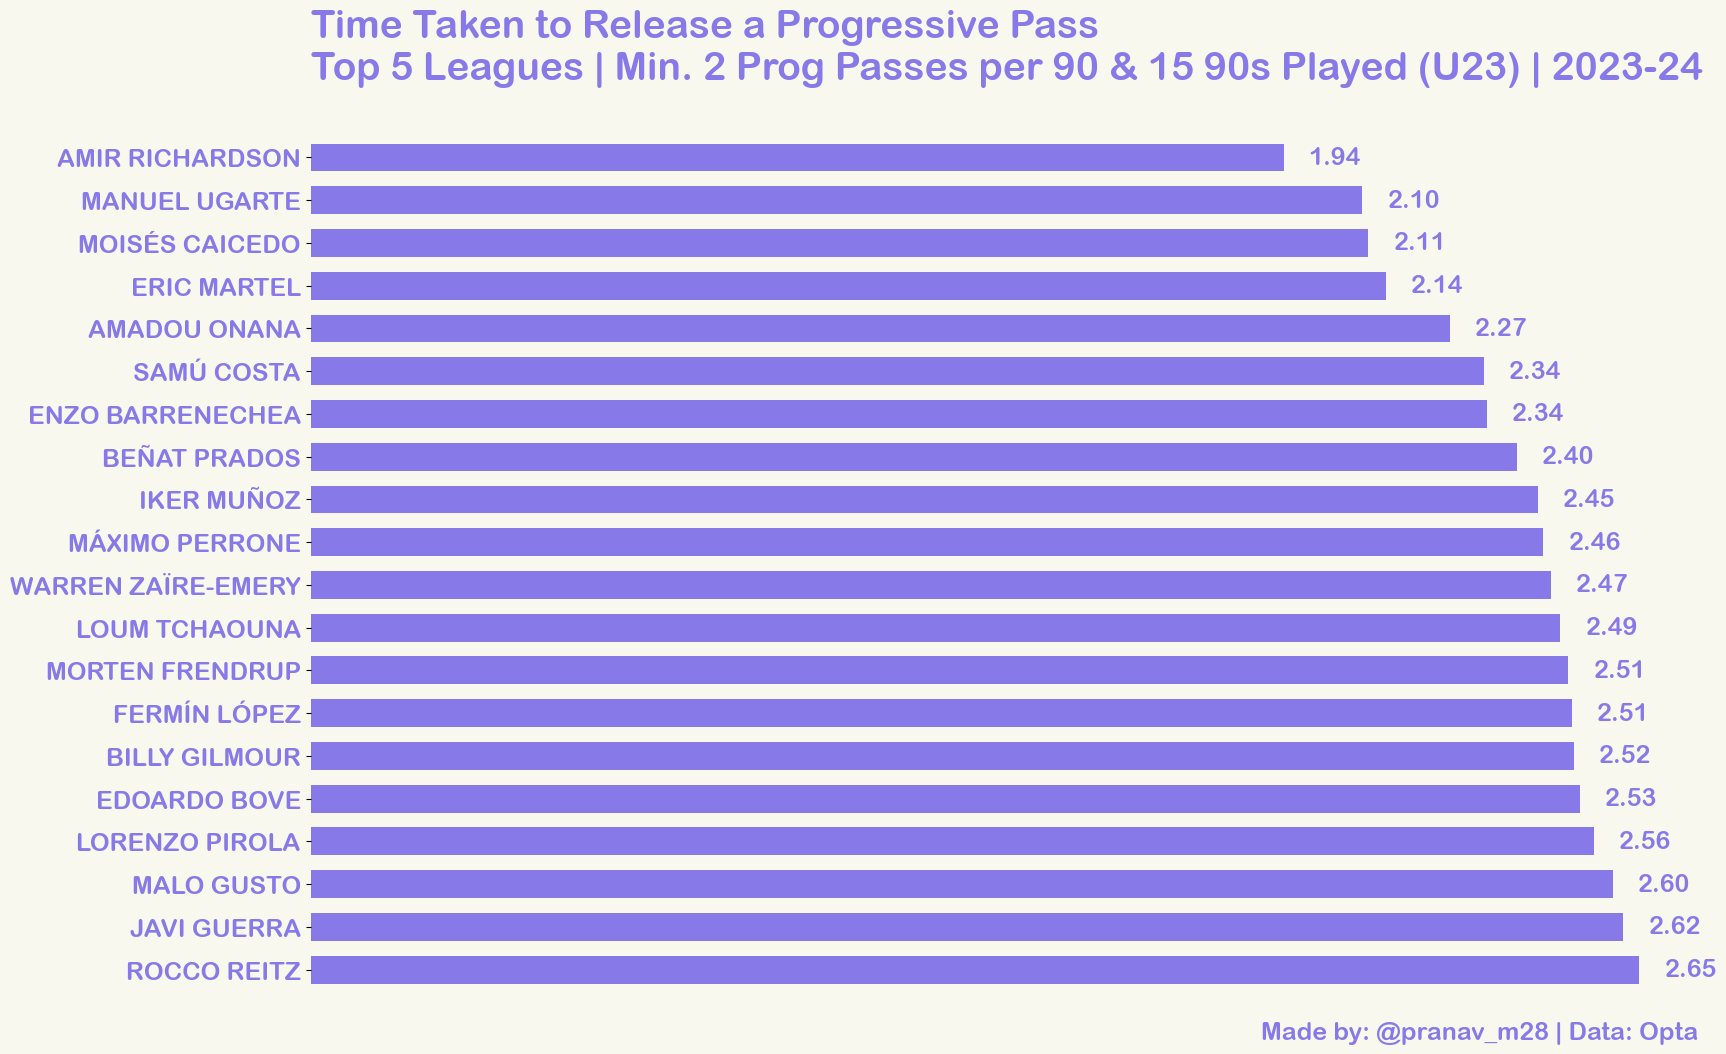

In [195]:
from matplotlib.font_manager import FontProperties
# Create the plot with the specified background color
fig, ax = plt.subplots(figsize=(18, 12))
fig.patch.set_facecolor('#f8f8ee')
ax.set_facecolor('#f8f8ee')

bars = ax.barh(disp2['player'], disp2['TTRP_per_prog_pass'], color='#877ae8', height=0.65)

# Set the title and labels with custom color
ax.text(0.0, 1.1, 'Time Taken to Release a Progressive Pass\nTop 5 Leagues | Min. 2 Prog Passes per 90 & 15 90s Played (U23) | 2023-24', font='Arial Rounded MT Bold', fontsize=28,
        color='#877ae8', ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel('Ball Retention %', font='Arial Rounded MT Bold', fontsize=12, color='#877ae8')

# Add a line below the title
#ax.axhline(y=-1.0, color='white', linewidth=1.5, alpha=0.5)  

# Set the font properties for player names and percentage labels
font_prop = FontProperties(family='Arial Rounded MT Bold', size=18)

# Add annotations with custom color and font properties
for bar in bars:
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.2f}', 
            va='center', ha='left', fontsize=18, color='#877ae8', fontproperties=font_prop)

# Invert the y-axis to have the player with the highest retention at the top
ax.invert_yaxis()

# Remove the x-axis numbers and ticks, but keep the player names on the y-axis
ax.tick_params(bottom=False, labelbottom=False)
ax.xaxis.set_visible(False)  # This removes the x-axis numbers

# Customize the y-axis tick labels
for tick in ax.get_yticklabels():
    tick.set_fontproperties(font_prop)
    tick.set_color('#877ae8')

# Remove the spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Add text for author and data source on the bottom right corner
ax.text(0.995, -0.02, 'Made by: @pranav_m28 | Data: Opta', font='Arial Rounded MT Bold',color='#877ae8', fontsize=18,
        ha='right', va='bottom', transform=ax.transAxes)


#plt.savefig("TTRP Prog Pass T5 u23.png" , dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

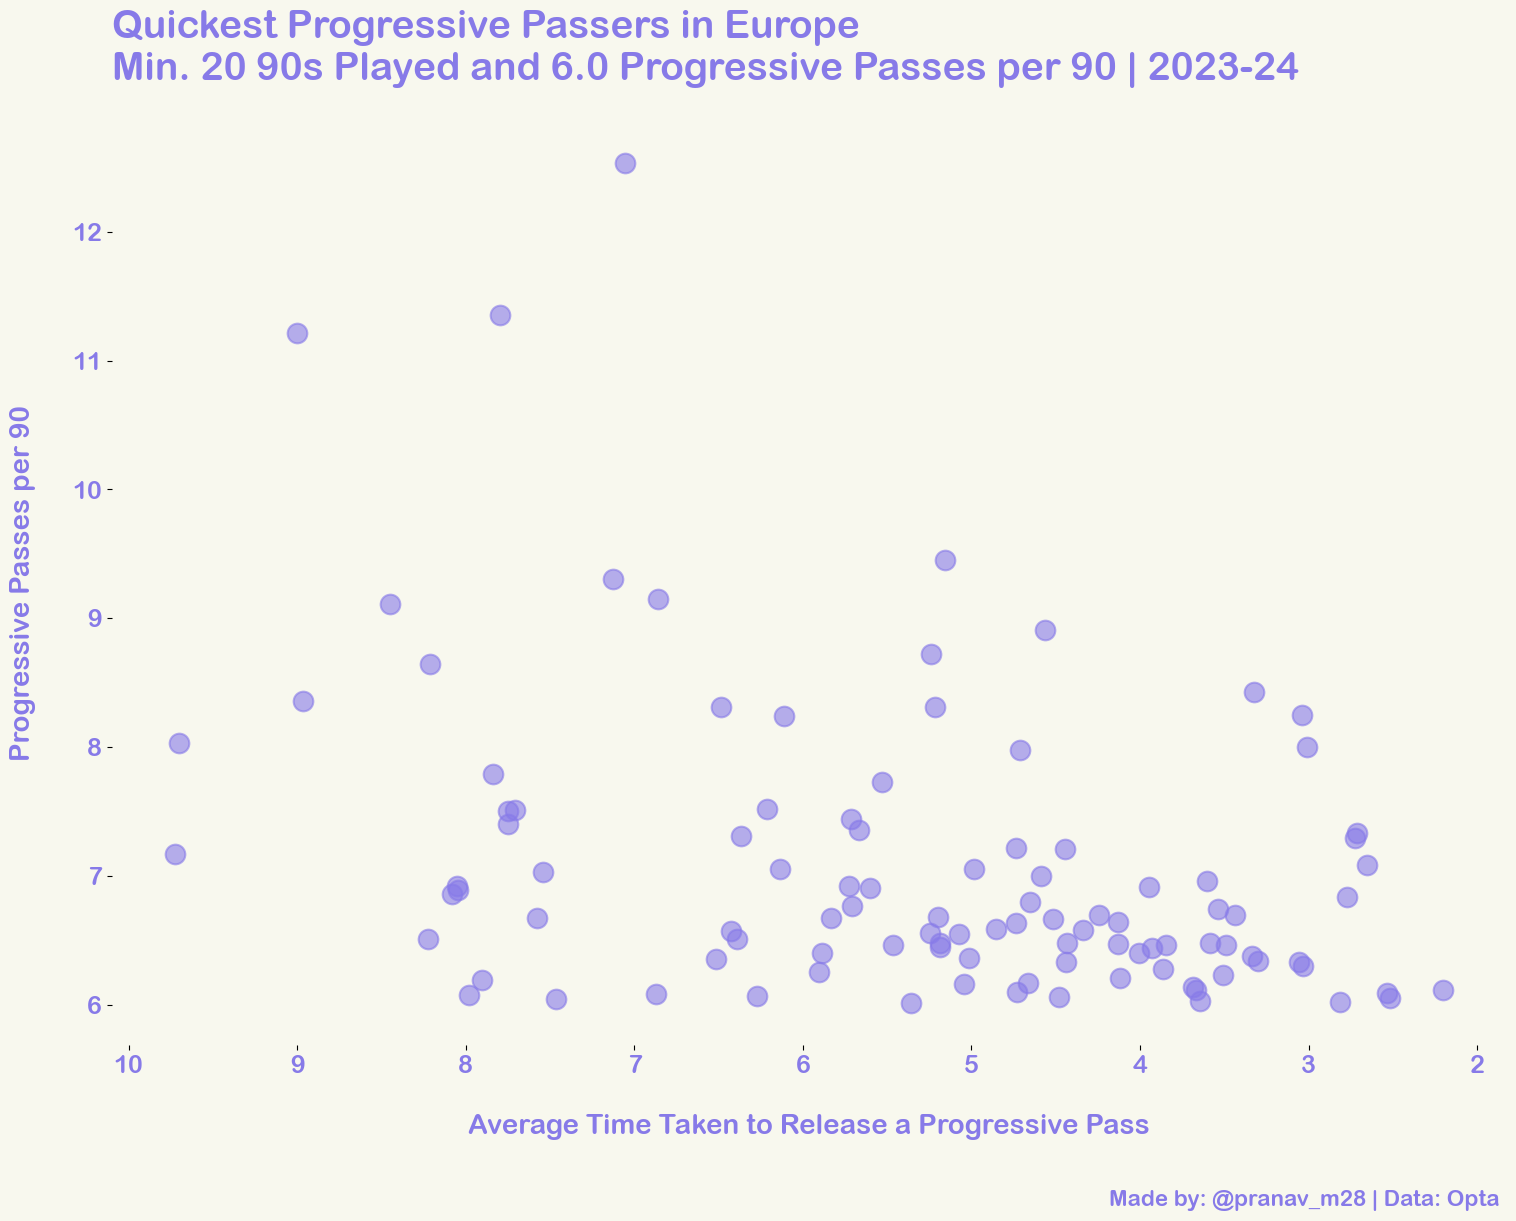

In [172]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# Create the plot with the specified background color
fig, ax = plt.subplots(figsize=(18, 12))
fig.patch.set_facecolor('#f8f8ee')
ax.set_facecolor('#f8f8ee')

plot = plt.scatter(disp['TTRP_per_prog_pass'], disp['prog_passes_p90'], color='#877ae8', s=200, alpha=0.6, linewidth=1.5)

# Set the title and labels with custom color
ax.text(0.0, 1.12, 'Quickest Progressive Passers in Europe\nMin. 20 90s Played and 6.0 Progressive Passes per 90 | 2023-24', 
        font='Arial Rounded MT Bold', fontsize=28, color='#877ae8', ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel('Average Time Taken to Release a Progressive Pass', font='Arial Rounded MT Bold', fontsize=20, color='#877ae8', labelpad=26)
ax.set_ylabel('Progressive Passes per 90', font='Arial Rounded MT Bold', fontsize=20, color='#877ae8', labelpad=26)

# Set the font properties for player names and percentage labels
font_prop = FontProperties(family='Arial Rounded MT Bold', size=18)

ax.invert_xaxis()

# Add player names below each scatter point
#for i, row in filter_actions.iterrows():
 #   if row['ball_won_hs_p90'] > 1.5 and row['tack+int_hs_p90'] > 0.5:
  #      ax.text(row['ball_won_hs_p90'], row['tack+int_hs_p90'], row['player'], 
   #             ha='center', va='center', fontsize=12, color='#877ae8', fontproperties=font_prop)

# Remove the x-axis numbers and ticks, but keep the player names on the y-axis
ax.tick_params(bottom=True, labelbottom=True)
ax.xaxis.set_visible(True)  # This removes the x-axis numbers

# Customize the y-axis tick labels
for tick in ax.get_yticklabels():
    tick.set_fontproperties(font_prop)
    tick.set_color('#877ae8')
    
# Customize the y-axis tick labels
for tick in ax.get_xticklabels():
    tick.set_fontproperties(font_prop)
    tick.set_color('#877ae8')

# Remove the spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Remove only the left spine
ax.spines['left'].set_visible(False)

# Add text for author and data source on the bottom right corner
ax.text(0.995, -0.18, 'Made by: @pranav_m28 | Data: Opta', font='Arial Rounded MT Bold', color='#877ae8', fontsize=16,
        ha='right', va='bottom', transform=ax.transAxes)


#plt.text(2.50, 92.46, 'Bellingham', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(2.28, 90.33, 'Andrich', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(2.52, 85.48, 'Kante', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(2.70, 88.35, 'Hjulmand', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(2.65, 90.79, 'Wirtz', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(2.71, 86.40, 'Onana', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(2.67, 94.28, 'Lobotka', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(2.77, 83.91, 'Orban', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(6.39, 90.15, 'Akanji', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(5.87, 91.68, 'Dias', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(4.99, 90.57, 'Van Dijk', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(4.62, 91.97, 'Bastoni', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(4.69, 88.40, 'Gvardiol', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(4.29, 90.33, 'Stones', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(5.15, 93.46, 'Skriniar', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(5.84, 86.31, 'Mitaj', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(3.29, 96.63, 'Christensen', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(3.88, 95.94, 'Saliba', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(3.54, 94.79, 'Tchouameni', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(3.05, 93.45, 'Rice', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(4.14, 94.49, 'Sutalo', font='Arial Rounded MT Bold', size=15, color='#877ae8')
#plt.text(2.81, 89.13, 'Højberg', font='Arial Rounded MT Bold', size=15, color='#877ae8')


#plt.text(2.60, 77, 'Quick but Unreliable', font='Arial Rounded MT Bold', size=20, color='#33b864')

#plt.text(6.40, 97.5, 'Slow but Reliable', font='Arial Rounded MT Bold', size=20, color='#33b864')

#plt.scatter(2.849, 93.032, color='#FF5959', s=200, alpha=0.6, lw=1.5)

#plt.savefig("Cala.png" , dpi=300, bbox_inches='tight')

# Display the plot
plt.show()